<br>
<u>Notebook Four</u> | 
<a href=https://leone.gdn/DLL target=_blank>Report</a> | 
<a href=https://github.com/andrealeone/DLL>Repository</a>
<br><br>
<b>Task 1: Attribute classifiers</b><br><br>
Andrea Leone, Alessandro E. Piotti<br>
Deep Learning Lab — University of Trento<br>
December 2021
<hr><br><br>

In [1]:
import project 

import os
import pickle
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import random
import collections

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchvision
import sklearn

from tqdm.notebook   import tqdm

project.notebook()

In [2]:
images, annotations = project.load_resources() 

<hr><br><br>

## `Clothes` classifier

<br><br>Load the train set, isolate the attribute as label, crop the image, and compute class weights

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({1: 11214, 0: 1775})
train:    Counter({1: 9613, 0: 1557})
test:     Counter({1: 1601, 0: 218})


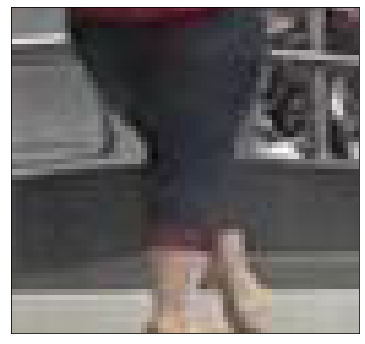

tensor([3.5870, 0.5810])

In [3]:
attribute  = 'clothes' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB

for image_file in tqdm(images):
    
    image_id = int(image_file.split('/')[-1].split('_')[0])
    
    label    = annotations.loc[image_id][attribute] - 1
    tensor   = torchvision.io.read_image( image_file, irm )
    
    ct = list()
    for c,channel in enumerate(tensor):
        ct.append( tensor[c][60:120].numpy() )
    
    tensor   = torch.tensor(ct).float()
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data, split_val)

project.inspect_dataset(data, train_set, test_set)

train_targets       = [y for _,y in train_set] 
train_class_weights = torch.tensor(
    sklearn.utils.class_weight.compute_class_weight(
        y=train_targets, classes=np.unique(train_targets),
        class_weight='balanced'
    ), dtype=torch.float
)

project.plot_image(train_set[0][0], fs=(16,6)) 
train_class_weights 

<hr><br><br>Fit a pretrained ResNet50 architecture

In [ ]:
v = '3_2'                       # model version 
e =  0                          # starting epoch


model     = torchvision.models.resnet50(pretrained=True) 
model.fc  = nn.Linear(
    in_features=model.fc.in_features,
    out_features=2, bias=True
)

if e > 0:
    w = './models/{}_resnet50.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )

    
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_resnet50.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name | epochs | accuracy           | precision | recall
#                 |        |                    |           |
# resnet50 v0.1   |  1     | 0.8680593732820231 | 0.6930304 | 0.7110693
# resnet50 v0.1   |  2     | 0.8873007146783948 | 0.7310353 | 0.6566179
# resnet50 v0.1   |  3     | 0.8878504672897196 | 0.7342730 | 0.6410801
# resnet50 v0.1   |  4     | 0.8867509620670698 | 0.7292474 | 0.6880060
# resnet50 v0.1   |  5     | 0.8982957669048928 | 0.7775630 | 0.6608828
# resnet50 v0.1   |  6     | 0.8999450247388675 | 0.7858950 | 0.6618197
#                 |        |                    |           |
# resnet50_v2     |  1-6   | 0.8790544255085212 | 0.4400110 | 0.4993753
#

<hr><br><br>Fit a custom CNN architecture

In [ ]:
v = '4'                         # model version 
e =  0                          # epoch counter


model = project.CNN(2048)

if e > 0:
    w = './models/{}_3cnv_5fc.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.AdamW(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_3cnv_5fc.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn 3cnv_5fc v1  |  4     | 0.8548653106102254 | /         | /
# c.cnn 3cnv_5fc v1  |  8     | 0.8620120945574490 | /         | /
#                    |        |                    |           |
# c.cnn 3cnv_5fc v4  |  1     | 0.8763056624518967 | 0.4398455 | 0.4978139
# c.cnn 3cnv_5fc v4  |  2     | 0.8790544255085212 | 0.4400110 | 0.4993754
# c.cnn 3cnv_5fc v4  |  3     | 0.3177570093457944 | 0.5143502 | 0.5252537
# c.cnn 3cnv_5fc v4  |  4     | 0.8521165475536009 | 0.5801000 | 0.5435106
# c.cnn 3cnv_5fc v4  |  5     | 0.8642111050027488 | 0.4554467 | 0.4929244
# c.cnn 3cnv_5fc v4  |  6     | 0.8653106102253986 | 0.5593891 | 0.5153430
# c.cnn 3cnv_5fc v4  |  7     | 0.8625618471687740 | 0.4390039 | 0.4900062
# c.cnn 3cnv_5fc v4  |  8     | 0.8570643210555250 | 0.5876567 | 0.5423588
# c.cnn 3cnv_5fc v4  |  9     | 0.8449697636063771 | 0.6031002 | 0.5810574
# c.cnn 3cnv_5fc v4  | 10     | 0.8328752061572292 | 0.5927779 | 0.5860744
#

<hr><br><br>

## `Up` classifier

<br><br>Load the train set, isolate the attribute as label, crop the image, and compute class weights

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({1: 12172, 0: 817})
train:    Counter({1: 10474, 0: 696})
test:     Counter({1: 1698, 0: 121})


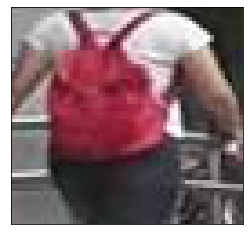

tensor([8.0244, 0.5332])

In [4]:
attribute  = 'up' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB

for image_file in tqdm(images):
    
    image_id = int(image_file.split('/')[-1].split('_')[0])
    
    label    = annotations.loc[image_id][attribute] - 1
    tensor   = torchvision.io.read_image( image_file, irm )
    
    ct = list()
    for c,channel in enumerate(tensor):
        ct.append( tensor[c][20:80].numpy() )
    
    tensor   = torch.tensor(ct).float()
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data, split_val)

project.inspect_dataset(data, train_set, test_set)

train_targets       = [y for _,y in train_set] 
train_class_weights = torch.tensor(
    sklearn.utils.class_weight.compute_class_weight(
        y=train_targets, classes=np.unique(train_targets),
        class_weight='balanced'
    ), dtype=torch.float
)

project.plot_image(train_set[0][0], fs=(16,4)) 
train_class_weights 

<hr><br><br>Fit a pretrained ResNet50 architecture

In [ ]:
v = '3_2'                       # model version 
e =  0                          # starting epoch


model     = torchvision.models.resnet50(pretrained=True) 
model.fc  = nn.Linear(
    in_features=model.fc.in_features,
    out_features=2, bias=True
)

if e > 0:
    w = './models/{}_resnet50.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_resnet50.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# resnet50 v0.1      |  1     | 0.9334799340296867 | 0.4667399 | 0.5
# resnet50 v0.1      |  2     | 0.9230346344145135 | 0.6600038 | 0.6018626
# resnet50 v0.1      |  3     | 0.8840021990104453 | 0.6066807 | 0.6577110
# resnet50 v0.1      |  4     | 0.8697086311159978 | 0.5980794 | 0.6692438
# resnet50 v0.1      |  5     | 0.8433205057724025 | 0.6064122 | 0.7472159
# resnet50 v0.1      |  6     | 0.8598130841121495 | 0.6025521 | 0.7023211
#                    |        |                    |           |
# resnet50 v0.2      |  1-2   | 0.4029686641011545 | 0.4881923 | 0.4955504
#

<hr><br><br>Fit a custom CNN architecture

In [ ]:
v = '4'                         # model version 
e =  0                          # epoch counter


model = project.CNN(2048)

optimizer = optim.AdamW(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_3cnv_5fc.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn 3cnv_5fc v1  |  4     | 0.9268829026937878 | /         | /
# c.cnn 3cnv_5fc v1  | 12     | 0.9081913139087411 | /         | /
#
# c.cnn 3cnv_5fc v4  |  1     | 0.9334799340296867 | 0.46674   | 0.5
# c.cnn 3cnv_5fc v4  |  2     | 0.9334799340296867 | 0.46674   | 0.5
# c.cnn 3cnv_5fc v4  |  3     | 0.9257833974711380 | 0.4664820 | 0.4958775
# c.cnn 3cnv_5fc v4  |  4     | 0.8905992303463441 | 0.4652499 | 0.4770318
# c.cnn 3cnv_5fc v4  |  5     | 0.9290819131390874 | 0.4665930 | 0.4976443
# c.cnn 3cnv_5fc v4  |  6     | 0.9334799340296867 | 0.46674   | 0.5
# c.cnn 3cnv_5fc v4  |  7     | 0.9334799340296867 | 0.46674   | 0.5
# c.cnn 3cnv_5fc v4  |  8     | 0.9329301814183617 | 0.4667217 | 0.4997055
# c.cnn 3cnv_5fc v4  |  9     | 0.9257833974711380 | 0.4664820 | 0.4958775
# c.cnn 3cnv_5fc v4  | 10     | 0.9257833974711380 | 0.4979721 | 0.4997153
#

<hr><br><br>

## `Down` classifier

<br><br>Load the train set, isolate the attribute as label, crop the image, and compute class weights

  0%|          | 0/12989 [00:00<?, ?it/s]

data:     Counter({1: 8157, 0: 4832})
train:    Counter({1: 7037, 0: 4133})
test:     Counter({1: 1120, 0: 699})


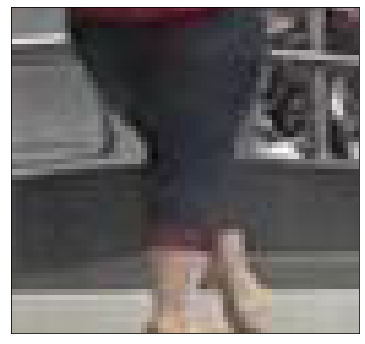

tensor([1.3513, 0.7937])

In [5]:
attribute  = 'down' 

split_val  = 640                # 751-640=151
dictionary = dict()
irm        = torchvision.io.ImageReadMode.RGB

for image_file in tqdm(images):
    
    image_id = int(image_file.split('/')[-1].split('_')[0])
    
    label    = annotations.loc[image_id][attribute] - 1
    tensor   = torchvision.io.read_image( image_file, irm )
    
    ct = list()
    for c,channel in enumerate(tensor):
        ct.append( tensor[c][60:120].numpy() )
    
    tensor   = torch.tensor(ct).float()
    
    if image_id not in dictionary:
        dictionary[image_id] = list()
        dictionary[image_id].append([tensor, label])
    else:
        dictionary[image_id].append([tensor, label])
    
data = list(dictionary.items())
random.Random(3).shuffle(data)

train_set, test_set = project.split_dataset(data, split_val)

project.inspect_dataset(data, train_set, test_set)

train_targets       = [y for _,y in train_set] 
train_class_weights = torch.tensor(
    sklearn.utils.class_weight.compute_class_weight(
        y=train_targets, classes=np.unique(train_targets), class_weight='balanced'
    ), dtype=torch.float
)

project.plot_image(train_set[0][0], fs=(16,6)) 
train_class_weights 

<hr><br><br>Fit a pretrained ResNet50 architecture

In [ ]:
v = '3_2'                       # model version 
e =  0                          # starting epoch


model     = torchvision.models.resnet50(pretrained=True) 
model.fc  = nn.Linear(
    in_features=model.fc.in_features,
    out_features=2, bias=True
)

if e > 0:
    w = './models/{}_resnet50.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_resnet50.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# resnet50 v0.1      |  1     | 0.7196261682242990 | 0.7452358 | 0.6542835
# resnet50 v0.1      |  2     | 0.7163276525563497 | 0.7068820 | 0.6723086
# resnet50 v0.1      |  3     | 0.7322704782847719 | 0.7220493 | 0.6954724
# resnet50 v0.1      |  4     | 0.7372182517866960 | 0.7221490 | 0.7191185
# resnet50 v0.1      |  5     | 0.7883452446399121 | 0.7769193 | 0.7851043
# resnet50 v0.1      |  6     | 0.7921935129191864 | 0.7827902 | 0.7723654
#                    |        |                    |           |
# resnet50 v0.2      |  1-2   | 0.5645959318306762 | 0.5340307 | 0.5329616
#

<hr><br><br>Fit a custom CNN architecture

In [ ]:
v = '4'                         # model version 
e =  0                          # epoch counter

model = project.CNN(2048)

if e > 0:
    w = './models/{}_3cnv_5fc.v{}.x{}.net'.format(attribute, v, e)
    model.load_state_dict( torch.load(w) )


optimizer = optim.AdamW(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(
    weight=train_class_weights, reduction='mean'
)


for i in range(10): 

    model_name = '{}_3cnv_5fc.v{}.x{}.net'.format(attribute, v, e+i+1)

    p = project.train(model, train_set,
        criterion, optimizer, epochs=1, li=500, monobatch=True
    )

    r = project.test(model, test_set, monobatch=True)

    project.save(model, './models/{}'.format(model_name))

In [ ]:
# SCORE BOARD 
# 
# net_design_name    | epochs | accuracy           | precision | recall
#                    |        |                    |           |
# c.cnn 3cnv_5fc v1  |  4     | 0.6981858163826278 | /         | /
# c.cnn 3cnv_5fc v1  |  8     | 0.7306212204507971 | /         | /
# c.cnn 3cnv_5fc v1  | 12     | 0.7157778999450247 | /         | /
#
# c.cnn 3cnv_5fc v2  |  1     | 0.6162726772952172 | 0.8080308 | 0.5007153
# c.cnn 3cnv_5fc v2  |  2     | 0.6168224299065420 | 0.6416621 | 0.5019684
# c.cnn 3cnv_5fc v2  |  3     | 0.6234194612424409 | 0.6952679 | 0.5116276
# c.cnn 3cnv_5fc v2  |  4     | 0.6140736668499175 | 0.5476055 | 0.5067271
# c.cnn 3cnv_5fc v2  |  5-10  | 0.6157229246838922 | 0.3078615 | 0.5
#
# c.cnn 3cnv_5fc v4  |  1     | 0.5596481583287520 | 0.4479413 | 0.4740925
# c.cnn 3cnv_5fc v4  |  2     | 0.7586586036283672 | 0.7613998 | 0.7760544
# c.cnn 3cnv_5fc v4  |  3     | 0.5882352941176471 | 0.5105129 | 0.5053731
# c.cnn 3cnv_5fc v4  |  4     | 0.5448048378229796 | 0.4806576 | 0.4848936
# c.cnn 3cnv_5fc v4  |  5     | 0.4777350192413414 | 0.3666504 | 0.4059613
# c.cnn 3cnv_5fc v4  |  6     | 0.5404068169323805 | 0.4143452 | 0.4555098
# c.cnn 3cnv_5fc v4  |  7     | 0.6118746564046179 | 0.5242270 | 0.5027903
# c.cnn 3cnv_5fc v4  |  8     | 0.6992853216052777 | 0.6949761 | 0.6428744
# c.cnn 3cnv_5fc v4  |  9     | 0.6162726772952172 | 0.5681320 | 0.5042107
# c.cnn 3cnv_5fc v4  | 10     | 0.6173721825178670 | 0.5983626 | 0.5042970
#
# c.cnn 3cnv_5fc v5  |  1     | 0.7251236943375481 | 0.7308848 | 0.7434447
# c.cnn 3cnv_5fc v5  |  2     | 0.7174271577789995 | 0.7228734 | 0.7350437
# c.cnn 3cnv_5fc v5  |  3     | 0.6877405167674546 | 0.7003903 | 0.7098610
# c.cnn 3cnv_5fc v5  |  4     | 0.6739967014843321 | 0.6894448 | 0.6976248
# c.cnn 3cnv_5fc v5  |  5     | 0.6487080813633864 | 0.6628195 | 0.6700982
# c.cnn 3cnv_5fc v5  |  6     | 0.6586036283672347 | 0.6724898 | 0.6802850
# c.cnn 3cnv_5fc v5  |  7     | 0.6558548653106102 | 0.6573433 | 0.6662222
# c.cnn 3cnv_5fc v5  |  8     | 0.6261682242990654 | 0.6379554 | 0.6445349
# c.cnn 3cnv_5fc v5  |  9     | 0.6250687190764156 | 0.6332095 | 0.6401466
# c.cnn 3cnv_5fc v5  | 10     | 0.6382627817482133 | 0.6366981 | 0.6444078
#

<br><br>